# Part I: Data preparation & analysis

## Add necessary imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load the dataset

In [2]:
train_skelletonpoints = pd.read_csv('./dataset_Seminar2/Train_skelletonpoints.csv', header = None, sep = ',')
test_skelletonpoints = pd.read_csv('./dataset_Seminar2/Test_skelletonpoints.csv', header = None, sep = ',')

train_features = pd.read_csv('./dataset_Seminar2/Train_features.csv', header = None, sep = ',')
test_features = pd.read_csv('./dataset_Seminar2/Test_features.csv', header = None, sep = ',')

train_labels = pd.read_csv('./dataset_Seminar2/Train_labels.csv', header = None, sep = ',')
test_labels = pd.read_csv('./dataset_Seminar2/Test_labels.csv', header = None, sep = ',')

print("Train skeleton points shape:", train_skelletonpoints.shape)
print("Test skeleton points shape:", test_skelletonpoints.shape)
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train skeleton points shape: (1000, 54)
Test skeleton points shape: (400, 54)
Train features shape: (1000, 270)
Test features shape: (200, 270)
Train labels shape: (1, 1000)
Test labels shape: (1, 200)


## Skelleton points into plots + pose label

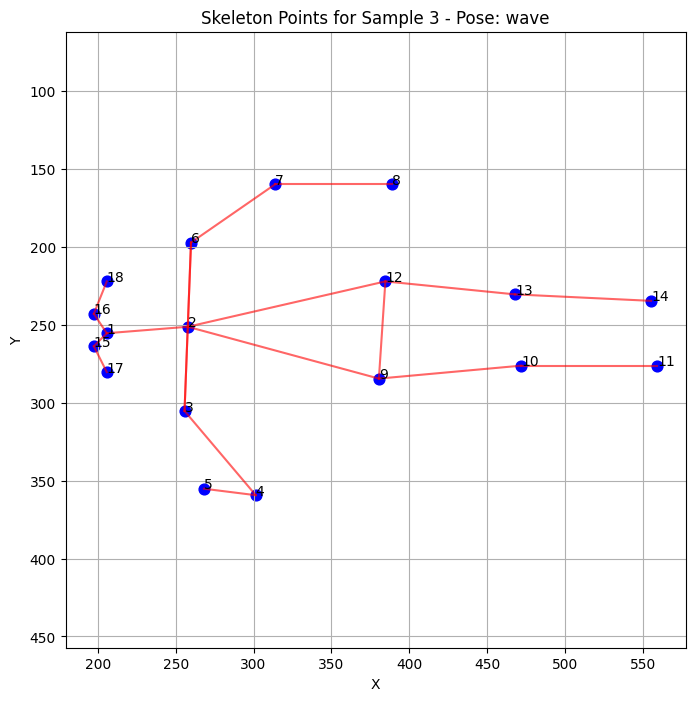

In [3]:
def plot_skeleton_with_label(skeleton_dataset, labels_dataset, sample_index=0):
    labels = labels_dataset.values.flatten()
    label_map = {1: 'wave', 2: 'push', 3: 'crouch', 4: 'sitdown', 5: 'bend'}

    # Extract skeleton points
    sample = skeleton_dataset.iloc[sample_index].values
    
    x = sample[0:18]
    y = sample[18:36]
    conf = sample[36:54]

    # MPII 18-keypoint connections (from slides)
    connections = [
        (0, 1),   # Nose - Neck
        (1, 2),   # Neck - Right Shoulder
        (2, 3),   # Right Shoulder - Right Elbow
        (3, 4),   # Right Elbow - Right Wrist
        (1, 5),   # Neck - Left Shoulder
        (5, 6),   # Left Shoulder - Left Elbow
        (6, 7),   # Left Elbow - Left Wrist
        (1, 8),   # Neck - Right Hip
        (8, 9),   # Right Hip - Right Knee
        (9, 10),  # Right Knee - Right Ankle
        (1, 11),  # Neck - Left Hip
        (11, 12), # Left Hip - Left Knee
        (12, 13), # Left Knee - Left Ankle
        (0, 14),  # Nose - Right Eye
        (0, 15),  # Nose - Left Eye
        (14, 16), # Right Eye - Right Ear
        (15, 17), # Left Eye - Left Ear
        (2, 5),   # Right Shoulder - Left Shoulder
        (8, 11),  # Right Hip - Left Hip
    ]

    plt.figure(figsize=(8, 8))
    # Draw connections
    for start, end in connections:
        plt.plot([x[start], x[end]], [y[start], y[end]], 'r-', alpha=0.6)
    # Draw keypoints
    plt.scatter(x, y, c='b', s=60, label='Keypoints')
    # Annotate keypoints
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.text(xi, yi, str(i+1), fontsize=10, color='black')
    # Get label and pose name
    label = labels[sample_index] # This will only be true if the labels index corresponds to the skeleton points sample. I did not understand how to obtain the pose if not like this.
    pose_name = label_map.get(label, f'Unknown ({label})')
    plt.title(f'Skeleton Points for Sample {sample_index} - Pose: {pose_name}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_skeleton_with_label(train_skelletonpoints, train_labels, sample_index= 3)

## Average CSI amplitude plot per subcarrier.

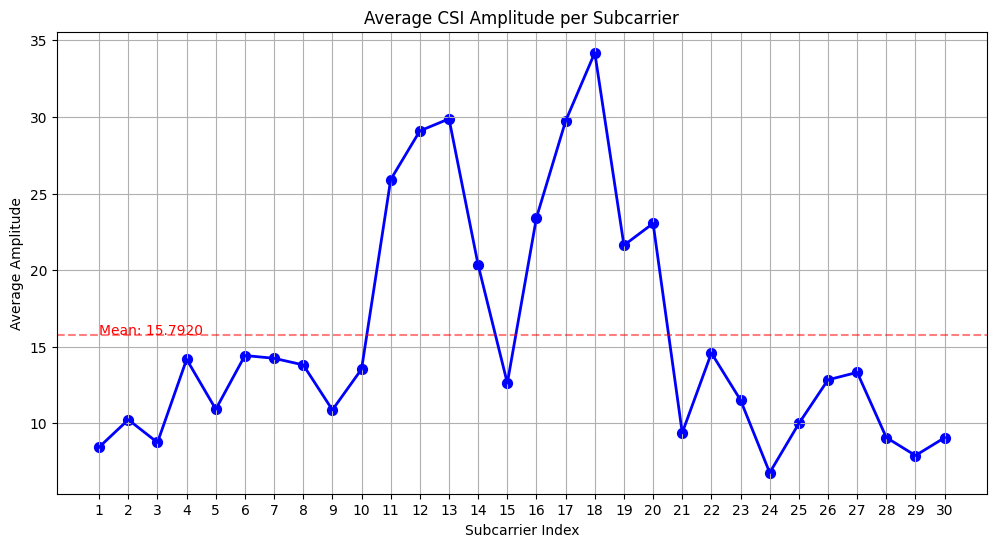

Average amplitude across all subcarriers: 15.7920


In [4]:
def plot_avg_csi_amplitude(csi_data, sample_idx=0):
    # Get the CSI data for the specified sample and convert to numpy array
    csi_sample = csi_data.iloc[sample_idx].values  # Convert pandas Series to numpy array
    
    # Reshape to (30, 3, 3)
    csi_reshaped = csi_sample.reshape(30, 3, 3)

    # Calculate average amplitude per subcarrier
    # We take the absolute value of the complex CSI and average across antenna pairs
    # axis=(1,2) means average across dimensions 1 and 2 (the 3x3 antenna matrix)
    # This leaves dimension 0 (30 subcarriers) as the result
    avg_amplitude = np.mean(np.abs(csi_reshaped), axis=(1, 2))
 
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), avg_amplitude, 'b-', linewidth=2)
    plt.scatter(range(1, 31), avg_amplitude, color='blue', s=50)
    
    plt.title('Average CSI Amplitude per Subcarrier')
    plt.xlabel('Subcarrier Index')
    plt.ylabel('Average Amplitude')
    plt.grid(True)
    plt.xticks(range(1, 31))
    
    # Add a horizontal line at the mean amplitude
    mean_amp = np.mean(avg_amplitude)
    plt.axhline(y=mean_amp, color='r', linestyle='--', alpha=0.5)
    plt.text(1, mean_amp, f'Mean: {mean_amp:.4f}', color='r')
    
    plt.show()
    
    return avg_amplitude

avg_amp = plot_avg_csi_amplitude(train_features, sample_idx=0)
print(f"Average amplitude across all subcarriers: {np.mean(avg_amp):.4f}")

##### The plot shows the average amplitude of Channel State Information (CSI) for each of the 30 subcarriers. Each point represents the mean amplitude (across all antenna pairs) for a specific subcarrier index. The plot reveals significant variation in amplitude across subcarriers, with some subcarriers (e.g., around indices 13–18) exhibiting much higher average amplitudes than others. This suggests that certain subcarriers may carry more discriminative information for downstream machine learning tasks using WiFi CSI data.

## Average CSI amplitude plot per subcarrier per class.

Class 1: wave, samples: 169
Class 2: push, samples: 210
Class 3: crouch, samples: 174
Class 4: sitdown, samples: 226
Class 5: bend, samples: 221


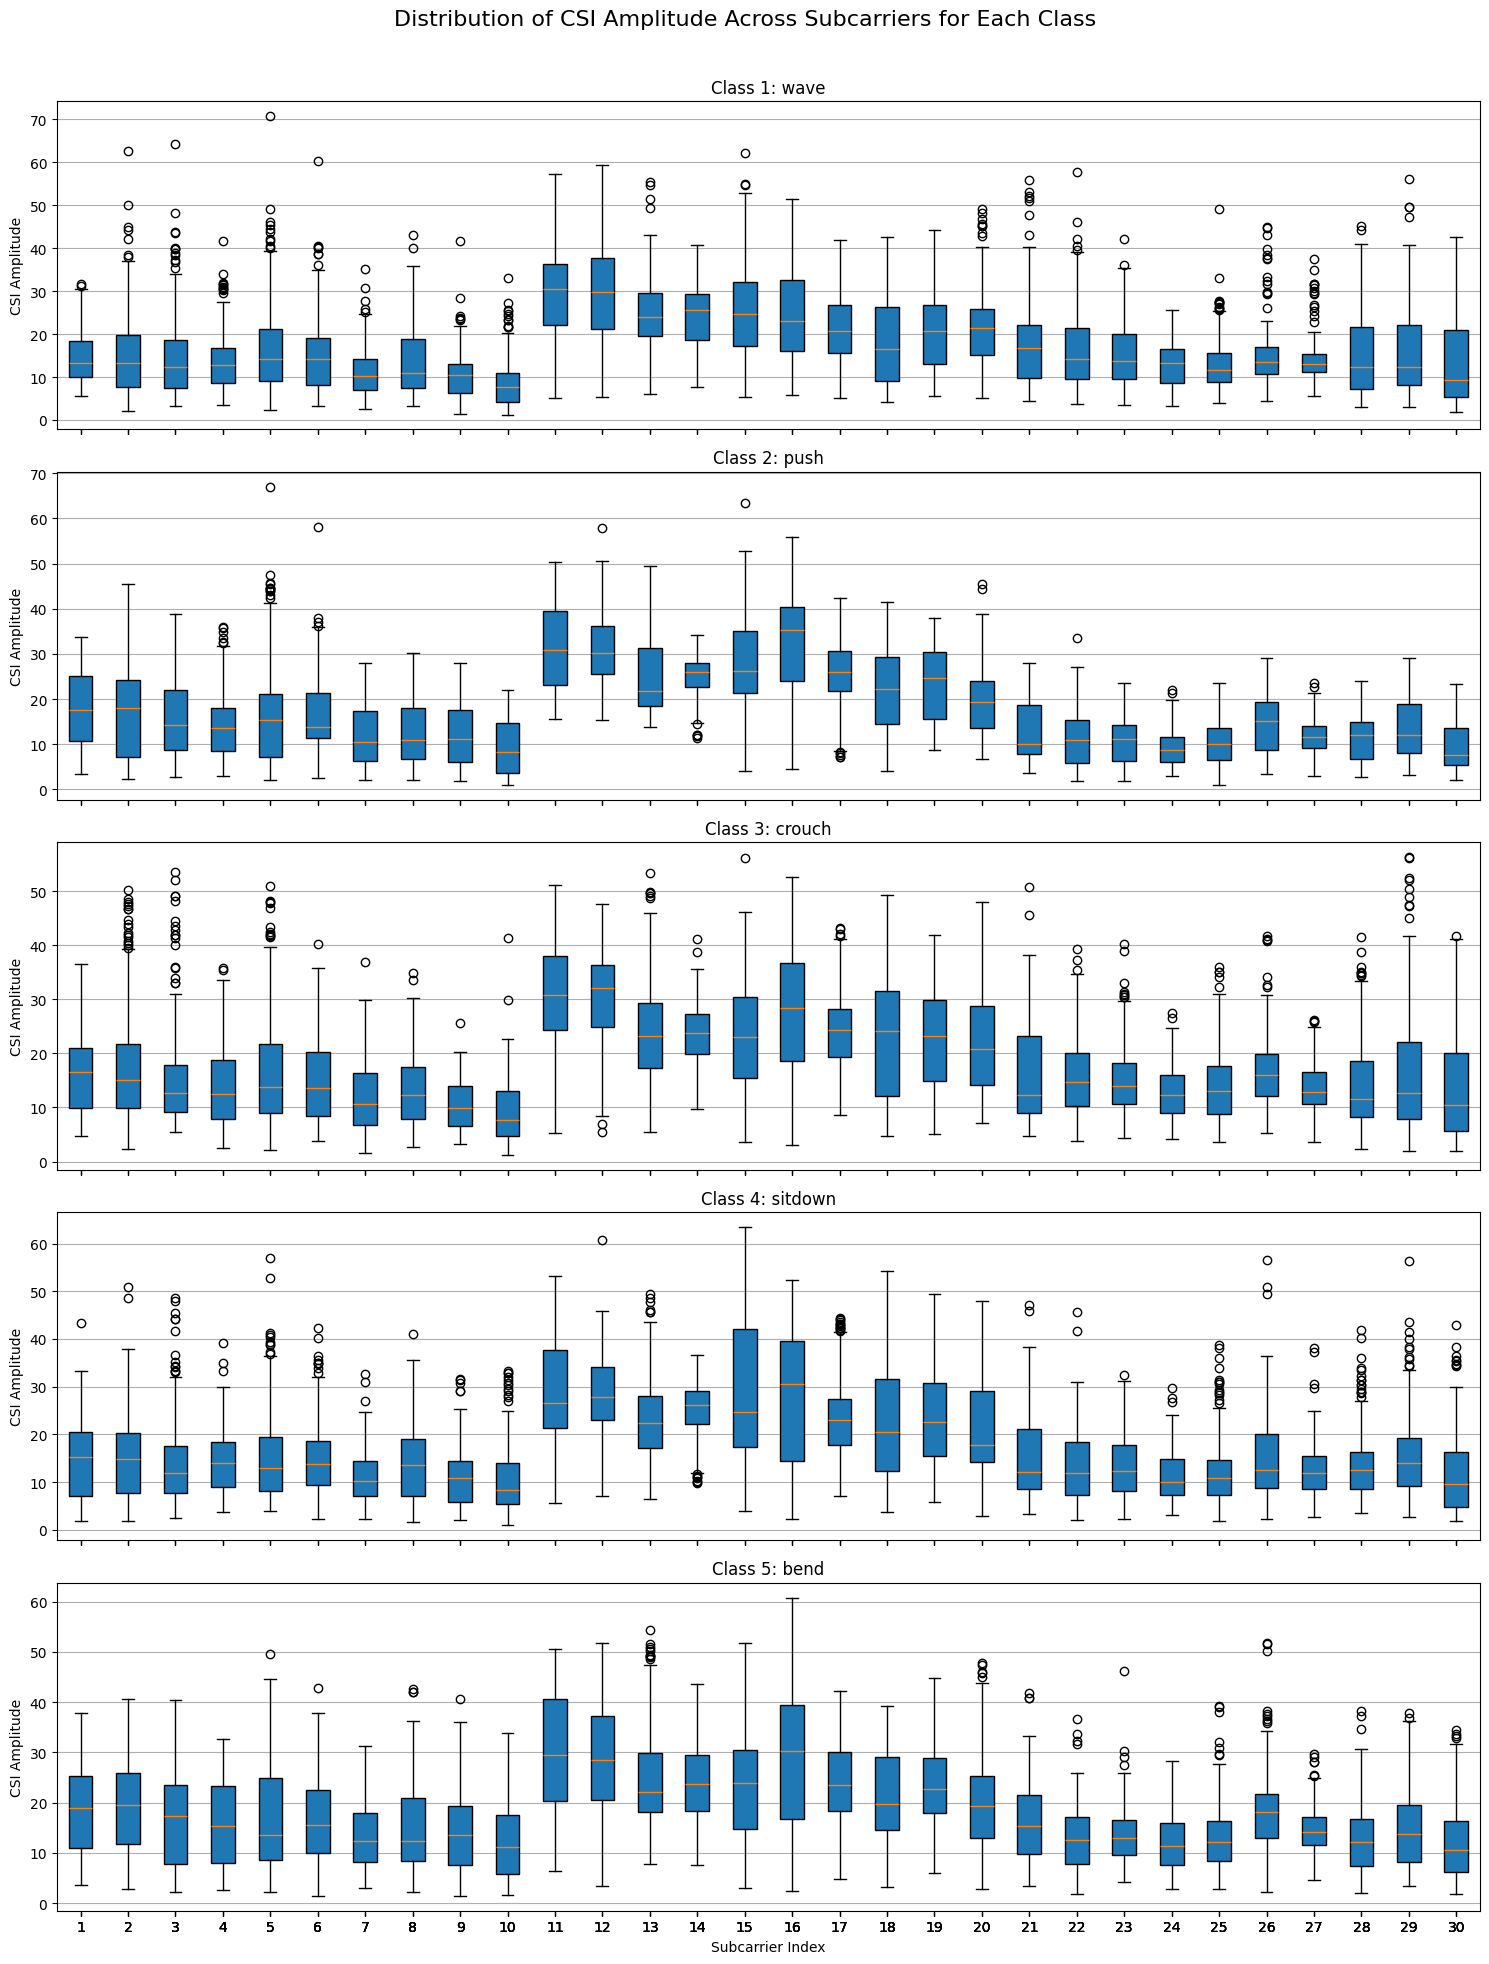

In [9]:
class_names = ['wave', 'push', 'crouch', 'sitdown', 'bend']

# Flatten labels
labels = np.array(train_labels).flatten()

def plot_csi_amplitude_distribution(csi_data, labels, num_classes=5):
    fig, axes = plt.subplots(num_classes, 1, figsize=(15, 4*num_classes), sharex=True)
    if num_classes == 1:
        axes = [axes]
    for class_idx in range(num_classes):
        class_mask = labels == (class_idx + 1)
        class_csi = csi_data[class_mask]
        print(f"Class {class_idx+1}: {class_names[class_idx]}, samples: {len(class_csi)}")
        if len(class_csi) == 0:
            continue
        all_amplitudes = []
        for i in range(len(class_csi)):
            csi_sample = np.array(class_csi.iloc[i]) if hasattr(class_csi, 'iloc') else np.array(class_csi[i])
            csi_reshaped = csi_sample.reshape(30, 3, 3)
            amplitude = np.abs(csi_reshaped).mean(axis=(1,2))
            all_amplitudes.append(amplitude)
        all_amplitudes = np.array(all_amplitudes)
        axes[class_idx].boxplot(all_amplitudes, positions=np.arange(1, 31), patch_artist=True)
        axes[class_idx].set_title(f"Class {class_idx+1}: {class_names[class_idx]}")
        axes[class_idx].set_ylabel("CSI Amplitude")
        axes[class_idx].grid(True, axis='y')
    axes[-1].set_xlabel("Subcarrier Index")
    plt.suptitle("Distribution of CSI Amplitude Across Subcarriers for Each Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_csi_amplitude_distribution(train_features, labels)

##### The above boxplots show the distribution of CSI amplitude across all 30 subcarriers for each activity class (wave, push, crouch, sitdown, bend). Each subplot corresponds to a different class, and each box represents the spread of amplitudes for a specific subcarrier. We observe that some subcarriers (especially those in the middle indices) tend to have higher median amplitudes and greater variability, while others are more stable across samples. This suggests that certain subcarriers may be more informative for distinguishing between activities, which is valuable for downstream machine learning tasks using WiFi CSI data.

# Part II: Model implementation

## Prepare the data

In [6]:
# Flatten labels
y_train = np.array(train_labels).flatten()
y_test = np.array(test_labels).flatten()
X_train = np.array(train_features)
X_test = np.array(test_features)

## Train the SVM Classifier

In [7]:
# SVM pipeline with scaling (important for SVMs)
svm_clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale', random_state=42))

# Fit the model
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, random_state=42))])

## Predict and Evaluate the model

Test Accuracy: 0.7700

Classification Report:
              precision    recall  f1-score   support

        wave       0.84      0.76      0.80        42
        push       0.71      0.82      0.76        39
      crouch       0.78      0.89      0.83        35
     sitdown       0.84      0.68      0.75        38
        bend       0.72      0.72      0.72        46

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200



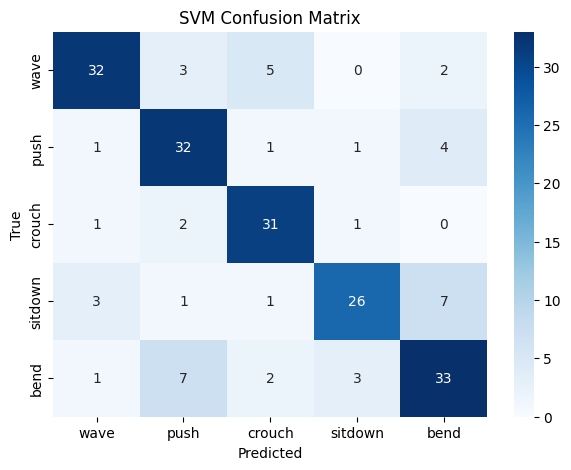

In [8]:
# Predict
y_pred = svm_clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed report
class_names = ['wave', 'push', 'crouch', 'sitdown', 'bend']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

##### The SVM classifier achieved a test accuracy of 0.77, indicating that it correctly classified 77% of the test samples.

- **Overall Performance**: The macro and weighted averages for precision, recall, and f1-score are all around 0.77–0.78, showing balanced performance across classes.
- **Class-wise Analysis**:
  - **Wave**: High precision (0.84) and good recall (0.76), meaning most predicted "wave" actions are correct, but some true "wave" actions are misclassified.
  - **Push**: Lower precision (0.71) but high recall (0.82), indicating some false positives but most "push" actions are detected.
  - **Crouch**: Strong performance with high recall (0.89) and f1-score (0.83), so the model is very good at identifying "crouch".
  - **Sitdown**: High precision (0.84) but lower recall (0.68), suggesting the model is conservative in predicting "sitdown" and misses some true cases.
  - **Bend**: Moderate and balanced precision and recall (both 0.72).

- **Confusion Matrix**: Most errors occur between similar actions (as for example between "bend" and "sitdown" or "push" and "bend").

**Summary**:  
The SVM model performs well overall, especially for "crouch" and "wave". Some confusion exists between similar activities, but the results are promising for a multi-class classification problem using WiFi-based features. Further improvements could focus on reducing confusion between overlapping classes.

How good the model is will be depending on the application, if we want to detect all the actions, the model is not good enough. But if we want to detect only some of the actions, the model is good enough.